In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Install IPD package
### Option 1 (from source):
1. Clone this github repo
2. Run `pip install -e .[render]` 
    1. Make sure you are using a compatible python version (tested with 3.10.14)
    2. Recommend using a venv

In [2]:
import intrinsic_ipd as ipd
from intrinsic_ipd import IPDataset, IPDCamera, IPDImage, IPDLightCondition
from intrinsic_ipd.constants import CameraFramework
import os
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True, precision=4)

In [3]:
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
os.environ['PYOPENGL_PLATFORM'] = 'egl'

## 2. Download (if not exists) and load dataset

In [5]:
ipd_reader = IPDataset("./datasets", "dataset_darkbg_0", IPDCamera.PHOTONEO, lighting=IPDLightCondition.ROOM, download=True, resize=.3) 
ipd_reader.objects

INFO:intrinsic_ipd.ipd:
	Dataset Path:	./datasets/dataset_darkbg_0/test
	Camera Type:	Photoneo (ID: 000)
	Lighting:	ROOM
	Resize:		0.3
	Num Scenes:	30


[('gear2', 0),
 ('gear2', 1),
 ('gear2', 2),
 ('gear2', 3),
 ('gear2', 4),
 ('hex_manifold', 0),
 ('hex_manifold', 1)]

## 3. Render Foundation Pose predictions

In [6]:
import yaml
import trimesh

In [7]:
file = "../FoundationPose/debug/ipd/dataset_darkbg_0_PHOTONEO.yml"
with open(file) as stream:
    pose_by_scene_part_object = yaml.safe_load(stream)

In [8]:
key = ("hex_manifold", 0)
scene = 30

In [9]:
_ , gt_poses = ipd_reader.get_scene_labels(scene) 
o2c_true = gt_poses[key]
o2c_true

array([[  -0.5601,   -0.3187,   -0.7647, -200.1112],
       [   0.8223,   -0.1015,   -0.56  , -149.5783],
       [   0.1009,   -0.9424,    0.3189, 1802.1769],
       [   0.    ,    0.    ,    0.    ,    1.    ]])

In [10]:
scene_poses = pose_by_scene_part_object[scene]
poses = { (part, object_id) : np.array(scene_poses[part][object_id]) for part in scene_poses for object_id in scene_poses[part]}
for key, pose in poses.items():
    poses[key][:3,3] *= 1e3
o2c_pred = poses[key]
o2c_pred

array([[  -0.102 ,   -0.8811,    0.4619, -177.419 ],
       [   0.0195,   -0.466 ,   -0.8846,   50.1999],
       [   0.9946,   -0.0812,    0.0647, 1757.9565],
       [   0.    ,    0.    ,    0.    ,    1.    ]])

In [11]:
im = ipd_reader.get_img(scene_id=scene, image_type=IPDImage.PHOTONEO_HDR)
color, depth = ipd_reader.render(scene_id=scene, poses=poses)

INFO:intrinsic_ipd.ipd:Opening image from ./datasets/dataset_darkbg_0/test/000030/000/rgb/000000.png


INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


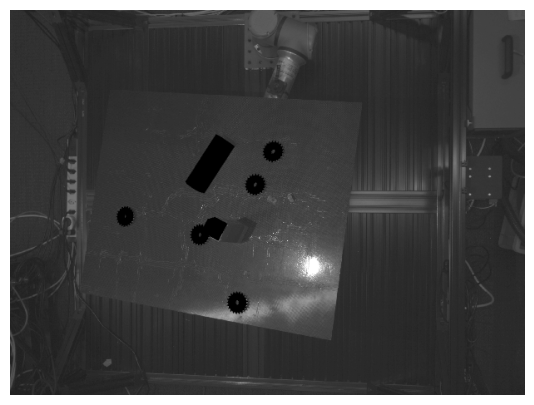

In [12]:
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(im, alpha=.9)
plt.imshow(color, alpha=1)
plt.show()

## 4. Compute baseline metrics

In [13]:
import pandas as pd

### Symmetry Correction Utils

In [14]:
from scipy.spatial.transform import Rotation as R
import itertools

def verify_symmetry(symm_params):
    """
    Examines a set of symmetry parameters and returns
    if they're valid.

    Args:
        symm_params (dict): See `vectorized_remove_symmetry` for in-depth description.

    Returns:
        Tuple(bool, str or None):
            - True if symmetry parameters are valid
            - Error message if symmetry parameters are not valid
    """

    num_cont = 0
    discrete_symmetries = []
    for axis in "xyz":
        if isinstance(symm_params.get(axis, None), dict):
            if symm_params[axis]["mod"] == 0:
                num_cont += 1
            else:
                discrete_symmetries.append(symm_params[axis]["mod"])

                if 360 % symm_params[axis]["mod"] != 0:
                    return False, "Discrete mod symmetry values must divide 360 evenly."

    if num_cont == 2:
        return False, "There can only be 0, 1, or 3 continuous symmetry axes on an object."

    if num_cont == 1:
        if len(set(discrete_symmetries).difference([180])) > 0:
            return False, "Only 180 degree symmetries are allowed for the other axes" \
                          " when a continuous symmetric axis is present."

    return True, None



def get_optim_params(x=None, y=None, z=None, ref_pose=None):

    result, message = verify_symmetry(dict(x=x, y=y, z=z))
    if not result:
        raise ValueError(f"Invalid Symmetry x={x}, y={y}, z={z}: " + message)

    symm_dims = [np.eye(3)]

    cont_symm_axes = []
    discrete_symms = dict(X=[0], Y=[0], Z=[0])

    if x is not None:
        if x["mod"] == 0:
            cont_symm_axes.append(0)
        else:
            for i in np.arange(0, 360, x["mod"]):
                if i == 0:
                    continue
                symm_dims.append(R.from_euler("xyz", [np.radians(i), 0, 0]).as_matrix())

            discrete_symms["X"] = np.arange(0, 360, x["mod"])

    if y is not None:
        if y["mod"] == 0:
            cont_symm_axes.append(1)
        else:
            for i in np.arange(0, 360, y["mod"]):
                if i == 0:
                    continue
                symm_dims.append(R.from_euler("yxz", [np.radians(i), 0, 0]).as_matrix())

            discrete_symms["Y"] = np.arange(0, 360, y["mod"])

    if z is not None:
        if z["mod"] == 0:
            cont_symm_axes.append(2)
        else:
            for i in np.arange(0, 360, z["mod"]):
                if i == 0:
                    continue
                symm_dims.append(R.from_euler("zyx", [np.radians(i), 0, 0]).as_matrix())

            discrete_symms["Z"] = np.arange(0, 360, z["mod"])

    proper_symms = []
    for axes in itertools.permutations("XYZ"):
        axes = "".join(axes)
        eulers = list(itertools.product(
            discrete_symms[axes[0]],
            discrete_symms[axes[1]],
            discrete_symms[axes[2]]
        ))
        proper_symms += [
            tuple(rotvec) for rotvec in R.from_euler(axes, eulers, degrees=True).as_rotvec()
        ]

    proper_symms = R.from_rotvec(proper_symms).as_matrix()
    # proper_symms may have duplicates, remove them
    diff_mat = np.linalg.norm(proper_symms[None] - proper_symms[:, None], axis=(-1, -2))
    proper_symms = proper_symms[[i for i, row in enumerate(diff_mat)
                                 if i == 0 or all(row[:i] > 1e-9)]]

    if ref_pose is None:
        ref_pose = np.eye(3)

    symmetry_mode = "full_discrete"
    if len(cont_symm_axes) > 1:
        symmetry_mode = "full_continuous"
    elif len(cont_symm_axes) == 1:
        symmetry_mode = "semi_continuous"

    params = dict(
        discrete_symm_rots=symm_dims,
        proper_symms=np.array(proper_symms),
        symmetry_mode=symmetry_mode,
        continuous_symm_axis=cont_symm_axes[-1] if len(cont_symm_axes) > 0 else -1,
        fix_continuous_symm_angles=len(cont_symm_axes) == 0,
        ref_pose=np.array(ref_pose)
    )

    return params

In [15]:
from scipy.spatial.transform import Rotation as R
def skew_symmetric_3(v):
    """
    Given a set of vectors v (Nx3), this function returns
    Nx3x3, the skew symmetric matrix of the vectors.
    """

    zero_arr = np.zeros(len(v))

    return np.transpose(np.array([
        [zero_arr, -v[:, 2], v[:, 1]],
        [v[:, 2], zero_arr, -v[:, 0]],
        [-v[:, 1], v[:, 0], zero_arr]
    ]), (2, 0, 1))

def vectorized_rot_between(vec1, vec2):
    """
    Given a set of normalized vectors, we compute the rotation matrix between
    the first set to the second set.

    Args:
        vec1 (np.array): Array of size Nx3
        vec2 (np.array): Array of size Nx3

    Returns:
        Rotation matrices R such that R[i] @ vec1[i] = vec2[i]
    """
    cosine = np.sum((vec1 * vec2), axis=1)

    result = np.zeros((len(cosine), 3, 3))
    result[cosine >= 1] = np.eye(3)
    result[cosine <= -1] = R.from_rotvec([0, np.pi, 0]).as_matrix()

    to_compute = np.where(np.abs(cosine) != 1)

    v = np.cross(vec1[to_compute], vec2[to_compute])
    v_x = skew_symmetric_3(v)

    result[to_compute] = np.eye(3)[None, :] + v_x + (v_x @ v_x) / (1 + cosine[to_compute][:, None, None])

    return result


def vectorized_remove_symmetry(poses, optim_params, inplace=True):
    """
    Given a set of symmetry parameters (see object_utils.get_optim_params) and input poses,
    this function reduces all poses that are considered rotationally symmetric with
    each other to the same pose. This is mostly important for 6DOF pose estimation.

    In general, the resulting pose is as close as possible to the "ref_pose" value
    (called the "reference pose") in the symmetry parameters, while still being
    symmetric to the input pose.

    There are three cases:
    1) An object has three continuous symmetry axes (i.e. it's a sphere)

        In this case, we reduce the poses to the reference pose.

    2) An object has one axis of continuous symmetry and up to 2 other
        discrete symmetries (which must be 180 degrees, if symmetric)

        If discrete symmetries exist, we flip the continuous axis to
        be as close as possible to the reference pose's corresponding axis.
        We then adjust the reference pose so that its corresponding axis
        aligns with the flipped or non-flipped continuous axis.

    3) An object has *only* discrete symmetries.

        In this case, we iterate through all symmetric transformations
        (which are encoded in the symmetry_parameters) and pick the
        one that transforms the input pose as close as possible
        to the reference pose (we use the Frobenius norm of the
        difference between the two poses).

    Args:
        poses (np.array): Nx4x4 NumPy array, pose to be reduced
        optim_params (dict): dict(
            proper_symms (np.array): Nx4x4, all discrete transformations
                between symmetric poses
            ref_pose (np.array): 4x4, the reference pose to reduce to
                (or to reduce close to)
            continuous_symm_axis (int): axis of continuous symmetry,
                if only one exists
            symmetry_mode (str): Is one of the following:
                "full_continuous": All three axes have continuous symmetry
                "semi_continuous": One axis has continuous symmetry
                "full_discrete": No axes have continuous symmetry
        )
        inplace (bool): If true, directly alters the passed in input pose.
                        Defaults to True.

    Returns:
        np.array: The symmetry reduced pose

    """

    if not inplace:
        poses = poses.copy()

    ref_pose = optim_params["ref_pose"]

    symm_reductions = optim_params["proper_symms"]

    if optim_params["symmetry_mode"] == "full_continuous":
        poses[:, :3, :3] = optim_params["ref_pose"]
    elif optim_params["symmetry_mode"] == "semi_continuous":
        cont_symm_axis_idx = optim_params["continuous_symm_axis"]

        has_no_discrete = np.all(np.isclose(np.eye(3)[None, :], symm_reductions))
        if not has_no_discrete:

            cont_axes = poses[:, :3, cont_symm_axis_idx]
            ref_axis = ref_pose[:, cont_symm_axis_idx]

            first_axis_dist = [
                np.linalg.norm(cont_axes - ref_pose[:, cont_symm_axis_idx][None, :], axis=1),
                np.linalg.norm(ref_pose[:, cont_symm_axis_idx][None, :] + cont_axes, axis=1)
            ]
            second_axis_dist = [
                np.linalg.norm(cont_axes - ref_pose[:, (cont_symm_axis_idx + 1) % 3][None, :], axis=1),
                np.linalg.norm(ref_pose[:, (cont_symm_axis_idx + 1) % 3][None, :] + cont_axes, axis=1)
            ]

            to_flip_first = first_axis_dist[0] > first_axis_dist[1]
            tie_breaker = np.isclose(first_axis_dist[0], first_axis_dist[1])
            to_flip_second = second_axis_dist[0] < second_axis_dist[1]
            to_flip_first[tie_breaker] = to_flip_second[tie_breaker]
            cont_axes[to_flip_first] *= -1

            ref_axis_broadcasted = np.broadcast_to(ref_axis, cont_axes.shape)
            poses[:, :3, :3] = vectorized_rot_between(ref_axis_broadcasted, cont_axes) @ ref_pose[None, :]
        else:
            removal_axes = ["xyx", "yxy", "zyz"][cont_symm_axis_idx]

            eulers = R.from_matrix(poses[:, :3, :3]).as_euler(removal_axes)
            eulers[:, 0] = 0
            poses[:, :3, :3] = R.from_euler(removal_axes, eulers).as_matrix()

    else:
        all_poses = poses[:, None, :3, :3] @ symm_reductions[None, :]
        dists = np.sum((all_poses - ref_pose[None, :])**2, axis=(-2, -1))

        best_symm_reduce = symm_reductions[np.argmin(dists, axis=1)]
        poses[:, :3, :3] = poses[:, :3, :3] @ best_symm_reduce

    return poses

### Measure Error

In [16]:
def add(pose_est, pose_gt, pts, symmetry_params):
    """Average Distance of Model Points for objects with no indistinguishable
    views - by Hinterstoisser et al. (ACCV'12).

    :param pose_est: 4x4 ndarray with the estimated pose transform matrix.
    :param pose_gt: 4x4 ndarray with the ground-truth pose transform matrix.
    :param pts: nx3 ndarray with 3D model points.
    :return: The calculated error.
    """
    vertices = np.c_[pts, np.ones(len(pts))]
    pose_diff = pose_est - pose_gt  # 4 x 4
    pose_diff = np.squeeze(vectorized_remove_symmetry(np.expand_dims(pose_diff, axis=0), symmetry_params), axis = 0)
    return np.mean(np.linalg.norm(pose_diff@vertices.T, axis=0))


def mvd(pose_est, pose_gt, pts, symmetry_params):
    """Maximum Vertex Distance.

    :param pose_est: 4x4 ndarray with the estimated pose transform matrix.
    :param pose_gt: 4x4 ndarray with the ground-truth pose transform matrix.
    :param pts: nx3 ndarray with 3D model vertex points.
    :return: The calculated error.
    """
    vertices = np.c_[pts, np.ones(len(pts))]
    pose_diff = pose_est - pose_gt # 4 x 4
    pose_diff = np.squeeze(vectorized_remove_symmetry(np.expand_dims(pose_diff, axis=0), symmetry_params), axis = 0)
    return np.max(np.linalg.norm(pose_diff@vertices.T, axis=0))

In [20]:
def measure_scene(poses_est, poses_gt, reader, acc_fcn):
    keys = poses_est.keys()
    errors = {}
    for key in keys:
        part, _ = key
        pose_gt = poses_gt[key]
        pose_est = poses_est[key]
        mesh_file = reader.get_mesh_file(part)
        mesh = trimesh.load(mesh_file)
        points = mesh.vertices
        symmetry_params_raw = reader.get_symm(part)
        if symmetry_params_raw:
            symmetry_params = get_optim_params(**symmetry_params_raw)
        else:
            symmetry_params = get_optim_params()
        errors[key] = acc_fcn(pose_est, pose_gt, points, symmetry_params)
    return errors

In [24]:
errors_add = {}
errors_mvd = {}
print(ipd_reader.scenes.keys())
for scene in ipd_reader.scenes.keys():
    _ , gt_poses = ipd_reader.get_scene_labels(scene) 
    scene_poses = pose_by_scene_part_object[scene]
    poses = { (part, object_id) : np.array(scene_poses[part][object_id]) for part in scene_poses for object_id in scene_poses[part]}
    for key, pose in poses.items():
        poses[key][:3,3] *= 1e3
    errors_add[scene] = measure_scene(poses, gt_poses, ipd_reader, add)
    errors_mvd[scene] = measure_scene(poses, gt_poses, ipd_reader, mvd)


dict_keys([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59])


In [22]:
df = pd.DataFrame(errors_add)
display(df)

30         31         32         33         34  \
gear2        0   26.743425  26.206014  25.686298  26.143142  25.970852   
             1   26.673454  26.061208  25.604138  26.044318  25.833214   
             2   25.481388  25.506226  25.521736  25.551180  25.550546   
             3   26.370951  25.867894  25.576191  25.984648  25.704351   
             4   26.490216  26.032835  25.603988  25.933882  25.796377   
hex_manifold 0    5.372920   5.479644   4.132318   5.152718   5.396670   
             1  115.422587   9.331349  94.791775  95.865794   7.652391   

                       35         36         37         38         39  ...  \
gear2        0  26.394021  25.691928  25.809011  25.672380  26.341814  ...   
             1  26.327454  25.579668  25.755597  25.629468  25.528472  ...   
             2  26.345759  25.537851  25.545945  25.532848  26.419332  ...   
             3  26.466715  25.618283  25.891687  25.567583  26.602117  ...   
             4  26.247128  25.519910  25.713635  25.600145  26.242163  ...   
hex_manifold 0   4.759153   4.622193   5.122796   4.791649   4.502212  ...   
             1   6.649248  94.722641   8.152053  94.775850   7.013484  ...   

                       50         51         52         53         54  \
gear2        0  26.685089  26.153823  25.973992  26.048040  26.268932   
             1  26.845186  26.266997  26.138361  26.161099  26.223027   
             2  27.088838  25.991358  25.971283  26.345441  25.577148   
             3  27.204717  26.582596  26.349533  26.383590  26.375836   
             4  27.026931  26.389115  25.860742  26.293510  25.617080   
hex_manifold 0   7.222497   8.358464   7.265930   7.343570   6.170668   
             1  10.110651  10.382837  29.406518  12.729785  10.279099   

                       55         56         57         58         59  
gear2        0  25.913092  25.799216  26.308218  25.807590  26.133214  
             1  25.935165  25.594435  26.129361  25.681910  25.961923  
             2  25.890435  25.706565  25.533860  25.570670  25.506940  
             3  26.008264  25.663801  26.003419  25.617616  25.798489  
             4  26.102631  25.774264  26.255310  25.753325  26.037725  
hex_manifold 0   6.190020   4.955092   5.066309   5.176127   4.099240  
             1  95.001687   8.692275   9.726323  10.529671   9.482520  

[7 rows x 30 columns]

In [23]:
df = pd.DataFrame(errors_mvd)
display(df)

30         31          32          33         34  \
gear2        0   37.503471  37.324826   36.744080   37.450862  36.794374   
             1   37.479285  35.823511   34.762287   35.887889  35.632927   
             2   35.459711  35.754450   34.689412   34.687276  35.360622   
             3   37.843815  35.865518   35.738435   37.089084  35.968035   
             4   37.793358  36.275667   36.260322   36.590861  35.898484   
hex_manifold 0    5.991846  10.757271    6.171774    9.784479   9.656340   
             1  255.110711  10.685904  196.610682  200.592080   8.801211   

                       35          36         37          38         39  ...  \
gear2        0  37.901879   36.121938  36.270871   36.282143  36.953631  ...   
             1  36.564796   34.746726  35.199652   34.795607  35.825194  ...   
             2  37.313568   35.748951  36.299593   35.486793  37.704741  ...   
             3  37.959113   36.650830  36.806692   36.370905  38.047206  ...   
             4  37.419801   35.408295  36.514908   36.005973  37.909606  ...   
hex_manifold 0   9.182331    7.215472   6.552839    6.188354   6.121441  ...   
             1   6.948515  194.163653  10.499665  195.369536   7.956985  ...   

                       50         51         52         53         54  \
gear2        0  39.305495  37.638290  36.655296  37.707203  38.196575   
             1  39.605525  37.475655  38.241763  38.351870  36.870771   
             2  39.637686  38.081045  36.699229  38.526748  36.948401   
             3  39.067119  37.533579  38.779190  38.102391  37.632535   
             4  41.073811  38.901312  37.321333  39.934659  37.269918   
hex_manifold 0  10.625922  15.145649  10.014750  11.391716  10.930010   
             1  10.733945  12.731515  30.338073  13.171679  11.183572   

                        55         56         57         58         59  
gear2        0   37.220831  36.879093  37.722572  36.769450  37.286025  
             1   36.854806  35.367141  36.335551  35.483316  35.964639  
             2   35.939466  35.409952  36.539847  36.047616  35.753203  
             3   37.285223  36.035547  36.608128  35.969486  35.939453  
             4   38.623618  36.897868  37.663621  36.805368  37.108932  
hex_manifold 0    9.014848   6.815458   7.493594   7.424682   6.623607  
             1  197.898980  10.241656  13.565599  17.310080  11.575305  

[7 rows x 30 columns]

# Hacky Shit

## Download symmetry files

In [2]:
import os
import subprocess
from intrinsic_ipd.constants import CAD_FILES

def download_symmetry_files(cad_models, output_folder):
  """Downloads symmetry files for all CAD models into a specified folder.

  Args:
    cad_models: A list of CAD model names.
    output_folder: The path to the folder where the files should be downloaded.
  """

  # Create the output folder if it doesn't exist
  os.makedirs(output_folder, exist_ok=True)

  for cad_model in cad_models:
    # Construct the GCS path for the symmetry file
    gcs_path = f"gs://akasha-scratch-backup/bpvs_objects/bpvs_objects/demo_{cad_model}_symm.json"

    # Construct the output file path
    output_file = os.path.join(output_folder, f"{cad_model}_symm.json")

    # Download the file using gsutil
    command = ["gsutil", "cp", gcs_path, output_file]
    subprocess.run(command)

    print(f"Downloaded {cad_model}_symm.json to {output_folder}")


# download_symmetry_files(CAD_FILES, "./datasets/models/symmetry_files")
